In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


In [2]:
df_full = pd.read_csv('../data/regression_lufu_2021-08-03.csv')

In [3]:
selected = [
    'id', 'gender', 'apgar_5min',
    'respiration_inv_days',
    'respiration_non_inv_days',
    'early_onset_infection', 'steroids', 'bpd_severity',
    'gest_age', 'birth_weight_g','body_size_cm',
    'volume', 'volume_ratio', 
]



df_regression=df_full[selected]

# Add variable of respiratory support (invasive + non-invasive)
resp_support_days = df_regression['respiration_inv_days'].to_numpy()+df_regression['respiration_non_inv_days'].to_numpy()
df_regression.insert(5, "resp_support_days", resp_support_days, True)

# Change gender to numerical 
gender_dict = {'f':0, 'm':1}
df_regression.replace({"gender": gender_dict}, inplace=True)

# Create volume variable but normalized by the birth weight
volume_per_kg= df_regression['volume'].to_numpy()/df_regression['birth_weight_g'].to_numpy()
df_regression.insert(13, "volume_per_kg", volume_per_kg, True)

# Create binary prediction variables
binary_no_vs_all = df_regression['bpd_severity'].apply(lambda x: 0 if x < 1 else 1)
df_regression.insert(15, "bpd_no_vs_all", binary_no_vs_all, True)

binary_mild_vs_severe = df_regression['bpd_severity'].apply(lambda x: 0 if x < 2 else 1)
df_regression.insert(16, "bpd_mild_vs_severe", binary_mild_vs_severe, True)



/Users/castelblanco/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# RF Nested Cross Validation 

In [4]:
def nested_cross_validation(X, y, depth_array, random_states, n_splits_outer=5, n_splits_inner=5):
     
    repetition_n = []
    grid_best_scores = []
    grid_best_ps = []
    model_auc = []
    model_f1 = []
    outer_fold = []
    repetition_n = []
    model_feature_weights = []
    tprs = []
    fprs =[]
    thresholds = []
        
    for i in range(len(random_states)):
        random_state_i = random_states[i]

        p_grid = {
            "max_depth": depth_array,
                 }
        
        model_grid = RandomForestClassifier( 
            random_state=random_state_i
        )

        # OUTER FOLD
        outter_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=random_state_i).split(X, y)
        for j, (train, test) in enumerate(outter_cv):
            x_train = X.loc[train]
            y_train = y.loc[train]
            x_test = X.loc[test]
            y_test = y.loc[test]

            # Inner Fold => Find the best parameter
            inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=random_state_i)
            grid = GridSearchCV(estimator=model_grid, param_grid=p_grid, cv=inner_cv, scoring='f1')
            grid.fit(x_train,y_train)
            grid_best_scores.append(grid.best_score_)
            grid_best_ps.append(grid.best_estimator_.max_depth)

            # Use the best parameter of the inner fold on the test
            model_rf = RandomForestClassifier(
                random_state=random_state_i, 
                max_depth=grid.best_estimator_.max_depth
            ).fit(x_train, y_train)

            # Perform Predictions
            y_predictions = model_rf.predict(x_test)
            y_predict_proba = model_rf.predict_proba(x_test)[:,1]
            test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_predict_proba)
            
            auc_temp = roc_auc_score(y_test, y_predict_proba)
            f1_temp = f1_score(y_test, y_predictions, average='weighted')

            model_feature_weights.append(model_rf.feature_importances_)

            model_auc.append(auc_temp)
            model_f1.append(f1_temp)
            
            fprs.append(test_fpr)
            tprs.append(test_tpr)
            thresholds.append(test_thresholds)

            outer_fold.append(j)
            repetition_n.append(i)

    df_results = pd.DataFrame.from_dict({
    'repetition_n':repetition_n,
    'outer_fold':outer_fold,
    'grid_best_inner_f1': grid_best_scores,
    'grid_best_ps': grid_best_ps,
    'model_auc': model_auc,
    'model_f1': model_f1,
    'model_feature_weights':model_feature_weights,
    'fprs':fprs,
    'tprs':tprs,
    'thresholds':thresholds,
    })

    return df_results

In [5]:
def get_avg_auc_and_f1(df_in, print_out=True):   
    avg_by_repetition = df_in[['repetition_n','model_auc','model_f1']].groupby('repetition_n').mean()
    std_by_repetition = df_in[['repetition_n','model_auc','model_f1']].groupby('repetition_n').std()
    
    avg_auc = np.mean(avg_by_repetition['model_auc'].to_numpy())
    std_auc = np.mean(std_by_repetition['model_auc'].to_numpy())
    avg_f1 = np.mean(avg_by_repetition['model_f1'].to_numpy())
    std_f1 = np.mean(std_by_repetition['model_f1'].to_numpy())
    
    if print_out:
        print('auc',avg_auc, '+/-', std_auc)
        print('f1',avg_f1, '+/-', std_f1)
    return avg_auc, std_auc, avg_f1, std_f1

# Nested Cross Validation

In [6]:
random_array = [1,50,234,3,5,789,45,658,9,429]  
tree_depth = [3,4,5,6,7,8,9,10] 

### Only Volume Features

In [7]:
explanatory = [
    'volume_per_kg', 
    'volume_ratio', 
]

y_in=df_regression['bpd_no_vs_all']
X_in=df_regression[explanatory]

rf_only_volume = nested_cross_validation(X_in, y_in, depth_array=tree_depth, random_states=random_array)
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(rf_only_volume)


auc 0.8266156462585034 +/- 0.10638862093240002
f1 0.8022441157680966 +/- 0.0825171349946959


## Volume + Patient Features

In [8]:
explanatory = [
    'gender', 'gest_age', 'birth_weight_g','body_size_cm',
    'volume_per_kg', 'volume_ratio', 
]

y_in=df_regression['bpd_no_vs_all']
X_in=df_regression[explanatory]

rf_volume_subject = nested_cross_validation(X_in, y_in, depth_array=tree_depth, random_states=random_array)
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(rf_volume_subject)


auc 0.8916666666666666 +/- 0.07699886413773296
f1 0.8471205418916764 +/- 0.05785263292562579


## Volume + Patient + Clinical Features

In [9]:
explanatory = [
    'gender', 'gest_age', 'birth_weight_g','body_size_cm',
    'apgar_5min','early_onset_infection', 'steroids',
    'volume_per_kg', 'volume_ratio',
]

y_in=df_regression['bpd_no_vs_all']
X_in=df_regression[explanatory]

rf_volume_subject_clinical = nested_cross_validation(X_in, y_in, depth_array=tree_depth, random_states=random_array)
avg_auc, std_auc, avg_f1, std_f1 = get_avg_auc_and_f1(rf_volume_subject_clinical)


auc 0.8888605442176871 +/- 0.0794702660493235
f1 0.8510235420222333 +/- 0.06109875076068684


## Compare All

In [10]:
aucs = np.concatenate([
    rf_only_volume['model_auc'],
    rf_volume_subject['model_auc'],
    rf_volume_subject_clinical['model_auc'],
])

f1s = np.concatenate([
    rf_only_volume['model_f1'],
    rf_volume_subject['model_f1'],
    rf_volume_subject_clinical['model_f1'],]
)

selected_features = np.concatenate([
    np.repeat('V', len(rf_only_volume['model_auc'])),
    np.repeat('V + S', len(rf_volume_subject['model_auc'])),
    np.repeat('V + S + C', len(rf_volume_subject_clinical['model_auc'])),
]) 


df_plot_results = pd.DataFrame.from_dict({
    'auc':aucs,
    'f1':f1s,
    'Features': selected_features,
})

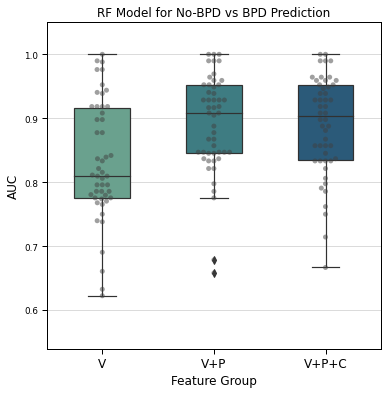

In [11]:
sns.set_context("paper")
font_s = 12

f = plt.figure(figsize=(6, 6))
gs = f.add_gridspec(1, 1)


ax = f.add_subplot(gs[0])
sns.boxplot(x='Features', y='auc',
            data=df_plot_results, 
            palette = 'crest',
            width = 0.5,
           )
sns.swarmplot(x='Features', y='auc',
              data=df_plot_results,
              color=".25",
              alpha=0.5
           )
ax.set_title('RF Model for No-BPD vs BPD Prediction', fontsize = font_s)
ax.set_ylabel('AUC', fontsize = font_s)
ax.set_xlabel('Feature Group', fontsize = font_s)
ax.set_ylim([0.54, 1.05])  


ax.set_xticklabels(['V','V+P','V+P+C'], fontsize = 12)
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray')


plt.savefig('RF_AUC.pdf')
plt.show()

## ROC for RF Model

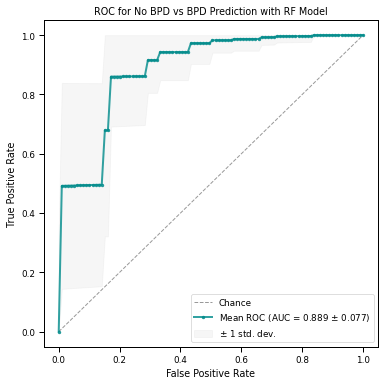

In [12]:
# Plot the ROC 

df_results = rf_volume_subject_clinical

tprs=df_results['tprs']
fprs=df_results['fprs']
aucs = df_results['model_auc']

tprs_interp =[]

#Interpolate tprs to find average for ROC 
mean_fpr = np.linspace(0, 1, 100)
for i in range(len(tprs)):
    tpr_temp = tprs[i]
    fpr_temp = fprs[i]
    interp_tpr_temp = np.interp(mean_fpr, fpr_temp, tpr_temp)
    tprs_interp.append(interp_tpr_temp)
    

# Plot ROC with Outer Folds
fig, ax = plt.subplots(figsize=(6, 6)) 

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs_interp, axis=0)
mean_tpr[-1] = 1.0
mean_tpr[0] = 0
#mean_auc = auc(mean_fpr, mean_tpr)
mean_auc=np.mean(aucs)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='darkcyan', marker='.',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs_interp, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='lightgrey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC for No BPD vs BPD Prediction with RF Model")
ax.legend(loc="lower right")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
#plt.savefig("roc_bpd_binary_RF.pdf")
plt.show()